In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import qutip as q
from spylind import spylind as spl
from spylind import spyIVP as spi
from spylind.tf_misc import InterpolatorMask, InterpolatorMaskArgs

from math import *
import numpy as np
import sympy as sm
from matplotlib.pyplot import *

No pretty printing stuff (probably because no Pandas)


## Qutip style problem definition

Munch({'tSym': t, 'dimSyms': [Delta], 'prop_state_syms': [\rho_{0|0}, \rho_{1|1}, \rho_{0|1}^r, \rho_{0|1}^i], 'stationary_state_syms': [], 'driving_syms': [E_r, E_i], 'state_dep_syms': [Delta]})
state dependent functions should have signature <itertools.chain object at 0x7faec81aca90>
num function evaluations: 132
CPU times: user 1.87 s, sys: 75.9 ms, total: 1.95 s
Wall time: 1.91 s


after JIT compiling, subsequent runs are much faster:
num function evaluations: 132
CPU times: user 91.9 ms, sys: 14.5 ms, total: 106 ms
Wall time: 46.4 ms


To avoid recompilation, change the driving fields using the methods on the interpolation oobjects (uses tensorflow variables)
num function evaluations: 852
CPU times: user 342 ms, sys: 92.4 ms, total: 435 ms
Wall time: 168 ms


Text(0.5, 1.0, 'excited state pop')

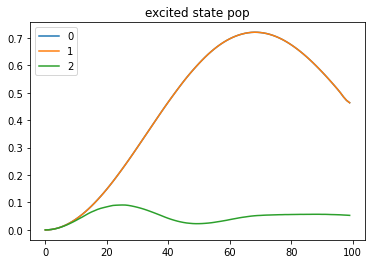

In [3]:

#problem definition
K1, K2  = q.basis(2,0), q.basis(2,1), 
tS, DeltaS = sm.symbols('t, Delta', real=True)
ES_r, ES_i = sm.symbols("E_r, E_i", real=True)
H0 = 2*pi*K2*K2.dag()
c_opL = [sqrt(.1)*q.sigmap()]

H_desc = [H0, [ES_r, q.sigmax()], [ES_i, q.sigmay()], [DeltaS, K2*K2.dag()] ]
eq, ex_vals=spl.makeMESymb(H_desc, c_opL=c_opL, e_opL = [], bReturnMatrixEquation=True)
lhsL, rhsL = spl.seperate_DM_equation(eq)

ode_s = spi.ODESolver(dict(zip(lhsL, rhsL) ),  dims={DeltaS:np.linspace(-2,2,100)}, driving_syms=[ES_r, ES_i], bDecompose_to_re_im=True, backend='tensorflow')
ode_s.set_initial_conditions(np.array([1,0,0]) )

tDrv = np.linspace(0,2.0,200) #Times where the value of the driving field is defined ("control points")
driving =  np.exp(1j*2*np.pi* tDrv)
driving_interpolator_r = InterpolatorMask(tDrv, driving.real) #These will interpolate between the supplied control points
driving_interpolator_i = InterpolatorMask(tDrv, driving.imag)
ode_s.set_driving({ES_r:driving_interpolator_r, ES_i:driving_interpolator_i}) # map the symbols ES_r and ES_i to the driving functions
ode_s.setup(bForceStateDimensions=True)

#Now run
tSteps = np.linspace(0,2.0, 100) # Times when values will be returned
%time res1= ode_s.integrate(tSteps)
print("\n")
print("after JIT compiling, subsequent runs are much faster:")
%time res2= ode_s.integrate(tSteps)
print('\n')
print("To avoid recompilation, change the driving fields using the methods on the interpolation oobjects (uses tensorflow variables)")
driving =  np.exp(2j*2*np.pi* tDrv)
driving_interpolator_r.set_y(driving.real)
driving_interpolator_i.set_y(driving.imag)
%time res3= ode_s.integrate(tSteps)

#Plotting
plot(res1[:,1].numpy().mean(axis=-1))
plot(res2[:,1].numpy().mean(axis=-1))
plot(res3[:,1].numpy().mean(axis=-1))
legend(np.arange(3))
title('excited state pop')


Note that changing 'tSteps', ie the time that results are returned at, triggers a recompile. 
Also note that having lots of 'tSteps' is expensive, but you usually don't need them if you only care about the final state.
In the below, the final state is essentially the same, despite only returning 5 steps

In [ ]:
tSteps = np.linspace(0,2.0, 5)#tDrv[:-1].copy()
res4 = ode_s.integrate(tSteps)
res3[-1,1].numpy().mean(), res4[-1,1].numpy().mean() #The last evaluated point is almost the same


## Different ways of defining the control points
Here we'll use modulation envelopes for the control points

In [ ]:
#Needs to be a function that takes a time tensor as arguemnt and returns a tf.tensor. May not work with non-tensorflow operations
drv_freq = tf.Variable(0.7, dtype='float64')
def f_r(t): #real field
    return driving_interpolator_r(t)*tf.cos(drv_freq*2*pi*t)
def f_i(t): #imaginary
    return driving_interpolator_i(t)*tf.sin(drv_freq*2*pi*t)
ode_s = spi.ODESolver(dict(zip(lhsL, rhsL) ),  dims={DeltaS:np.linspace(-2,2,100)}, driving_syms=[ES_r, ES_i], bDecompose_to_re_im=True, backend='tensorflow')
ode_s.set_initial_conditions(np.array([1,0,0]) )

tDrv = np.linspace(0,2.0,200) #Times where the value of the driving field is defined ("control points")

ode_s.set_driving({ES_r:f_r, ES_i:f_i})
ode_s.setup(bForceStateDimensions=True)
driving = np.ones(tDrv.size)*(0.5 + 0.5j)
driving_interpolator_r.set_y(driving.real)
driving_interpolator_i.set_y(driving.imag)

tSteps = np.linspace(0,2,200)
%time states= ode_s.integrate(tSteps)
plot(states[:,:,50])

In [ ]:
driving = np.ones(tDrv.size)*(1. + 0.5j)
driving_interpolator_r.set_y(driving.real)
driving_interpolator_i.set_y(driving.imag)
drv_freq.assign(0.2)
tSteps = np.linspace(0,2,200)
%time states= ode_s.integrate(tSteps)
plot(states[:,:,50])

# Calculating gradients:
Easiest way is to wrap it all in a "GradientTape"

/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


num function evaluations: 2394
CPU times: user 4.34 s, sys: 69 ms, total: 4.41 s
Wall time: 4.45 s
CPU times: user 4.42 s, sys: 49 ms, total: 4.47 s
Wall time: 4.05 s


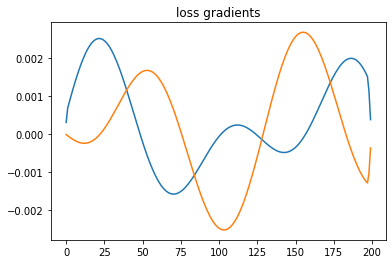

In [25]:
import MT
with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(driving_interpolator_r.yOrig)
    tape.watch(driving_interpolator_i.yOrig)
    tape.watch(drv_freq)

    %time res2= ode_s.integrate(tSteps)#, grad_pair=grad_pair 
    %time grad_r, grad_i=tape.gradient(tf.reduce_mean(res2[-1][1]), (driving_interpolator_r.yOrig, driving_interpolator_i.yOrig))
grad = grad_r.numpy() + 1j*grad_i.numpy()

title('loss gradients')
plot(grad.real, label='real')
plot(grad.imag, label='imag')
#xlim([25, 30])

Because of the adaptive stepping, gradients can be a little jagged due to some steps sample more than others. Doing a moving average of 2 points gets rid of some of it. Not sure how sustainable this is

(75.0, 125.0)

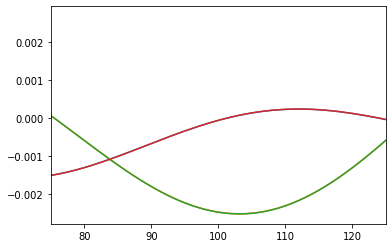

In [26]:
import MT
smth = lambda y: MT.smooth(y,2+1) # This actually should be a moving average of 2 (dont' ask why)
plot(smth(grad.real) )
plot(smth(grad.imag))
plot(grad.imag)
plot(grad.real )
xlim([75,125])


## Optimize:

In [27]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import tensorflow_probability as tfp
import qutip as q
from spylind import spylind as spl
from spylind import spyIVP as spi
from spylind.tf_misc import InterpolatorMask, InterpolatorMaskArgs

from math import *
import numpy as np
import sympy as sm
from matplotlib.pyplot import *


#problem definition
K1, K2  = q.basis(2,0), q.basis(2,1), 
tS, DeltaS = sm.symbols('t, Delta', real=True)
ES_r, ES_i = sm.symbols("E_r, E_i", real=True)
H0 = 0*pi*K2*K2.dag()
c_opL = [sqrt(.1)*q.sigmap()]

H_desc = [H0, [ES_r, q.sigmax()], [ES_i, q.sigmay()], [DeltaS, K2*K2.dag()] ]
eq, ex_vals=spl.makeMESymb(H_desc, c_opL=c_opL, e_opL = [], bReturnMatrixEquation=True)
lhsL, rhsL = spl.seperate_DM_equation(eq)

ode_s = spi.ODESolver(dict(zip(lhsL, rhsL) ),  dims={DeltaS:np.linspace(-.01,.01,100)}, driving_syms=[ES_r, ES_i], bDecompose_to_re_im=True, backend='tensorflow')
ode_s.set_initial_conditions(np.array([1,0,0]) )


tDrv = np.linspace(0,2.0,20)
tSteps = np.linspace(0,2.0, 100)#tDrv[:-1].copy()

tDrv -= (tDrv[1]-tDrv[0])/2


driving =  np.exp(1j*2*np.pi* tDrv)

driving_interpolator_r = InterpolatorMask(tDrv, driving.real)
driving_interpolator_i = InterpolatorMask(tDrv, driving.imag)

def f_r(t):
    return driving_interpolator_r(t)*tf.cos(2*pi*t)
def f_i(t):
    return driving_interpolator_i(t)*tf.sin(2*pi*t)

#ode_s.set_driving({ES_r:driving_interpolator_r, ES_i:driving_interpolator_i})
ode_s.set_driving({ES_r:f_r, ES_i:f_i})

ode_s.setup(bForceStateDimensions=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Munch({'tSym': t, 'dimSyms': [Delta], 'prop_state_syms': [\rho_{0|0}, \rho_{1|1}, \rho_{0|1}^r, \rho_{0|1}^i], 'stationary_state_syms': [], 'driving_syms': [E_r, E_i], 'state_dep_syms': [Delta]})
state dependent functions should have signature <itertools.chain object at 0x7c8d3eba28b0>


## Problem: 
going back go adaptive stepping seems to be screwing things up as they cause noisy gradients. If you 'encourage' similar step sizes, things improve, but it still gets stuck in local minima due to the stepping noise.

In [28]:
import MT
from scipy import optimize
smth = lambda x: x
def stack(cmplx):
    return np.hstack([cmplx.real,cmplx.imag])
def unstack(stacked):
    return stacked[:N] + 1j * stacked[N:]

N = tDrv.size
drv0 = np.where(tDrv<1, 0, 5.0)*np.exp(0*pi*1j*tDrv)#np.ones(tDrv.size)*(.1 + 0j)

def just_run(driving):
    drv_r, drv_i = driving[:N], driving[N:]
    driving_interpolator_r.set_y(drv_r)
    driving_interpolator_i.set_y(drv_r)
    res= ode_s.integrate(tSteps)
    return res
def get_loss(driving):
    drv_r, drv_i = driving[:N], driving[N:]
    driving_interpolator_r.set_y(drv_r)
    driving_interpolator_i.set_y(drv_r)

    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(driving_interpolator_r.yOrig)
        tape.watch(driving_interpolator_i.yOrig)

        res= ode_s.integrate(tSteps, first_step_size=1e-3, safety_factor=0.01, max_step_size_factor=2.0, atol=1e-12, rtol=1e-8)#, first_step_size=0.01, safety_factor=0.1, min_step_size_factor =1-1e-5, max_step_size_factor=1 + 1e-4, atol=1e10, rtol=1e10)#, grad_pair=grad_pair 
                res= ode_s.integrate(tSteps, first_step_size=1e-3, safety_factor=0.01, max_step_size_factor=2.0, atol=1e-12, rtol=1e-8)#, first_step_size=0.01, safety_factor=0.1, min_step_size_factor =1-1e-5, max_step_size_factor=1 + 1e-4, atol=1e10, rtol=1e10)#, grad_pair=grad_pair 

        L = tf.reduce_mean(1-res[-1,1]**2)
       # tf.reduce_mean(1-arr[-1,2]**2)
        grad_r, grad_i=tape.gradient(L, (driving_interpolator_r.yOrig, driving_interpolator_i.yOrig))
    L =L.numpy()
    print("Loss: ", L)
    return L, np.hstack([smth(grad_r.numpy()), 1*smth(grad_i.numpy()) ])
#driving
#get_loss(stack(drv0) )
res=optimize.minimize(get_loss, stack(drv0), jac=True) #jac=True means the second return value from "get_loss" is the gradient

/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


TypeError: in user code:

    /home/morgan/sd_base/home_dir/git/spylind/spylind/spyIVP.py:764 integrate_tf  *
        results_obj =tfp.math.ode.FixedStep(**kwargs).solve(self.d_dt_fast.__call__, tSteps[0], yInit, solution_times=tSteps)

    TypeError: __init__() got an unexpected keyword argument 'first_step_size'


In [51]:
#continue from above
res=optimize.minimize(get_loss, res.x, method='CG', jac=True, options={'maxiter':20})

/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


num function evaluations: 1536
0.050040093402770956
num function evaluations: 1512
0.049911503093696304
num function evaluations: 1458
0.04970823346384359
num function evaluations: 1428
0.04954958920786658
num function evaluations: 1548
0.04991445468139654
num function evaluations: 1422
0.04954739300197139
num function evaluations: 1500
0.049307154907549645
num function evaluations: 1590
0.04999766839604881
num function evaluations: 1416
0.04967728307095201
num function evaluations: 1482
0.04895304066711273
num function evaluations: 1458
0.04884561873096348
num function evaluations: 1500
0.049278782101448385
num function evaluations: 1464
0.04892438292755687
num function evaluations: 1458
0.048846168314706145
num function evaluations: 1458
0.04884562549452692
num function evaluations: 1458
0.04884562182786357
num function evaluations: 1458
0.04884562142034939
num function evaluations: 1458
0.04884561873096348


/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


num function evaluations: 1512
0.049911503093696304
num function evaluations: 1500
0.04990876396615084
num function evaluations: 1536
0.04975128928536424
num function evaluations: 1500
0.04959003030433808
num function evaluations: 1548
0.04987252957802488
num function evaluations: 1464
0.04982035788826068
num function evaluations: 1518
0.04981142698318447
num function evaluations: 1500
0.04964350646314117
num function evaluations: 1470
0.04978218443616211
num function evaluations: 1494
0.049874910160665725
num function evaluations: 1470
0.04994153031530732
num function evaluations: 1476
0.04958162013542515
num function evaluations: 1470
0.04993614958689612
num function evaluations: 1470
0.04993344211040974
num function evaluations: 1476
0.04958290390005054
num function evaluations: 1476
0.049582463766757165


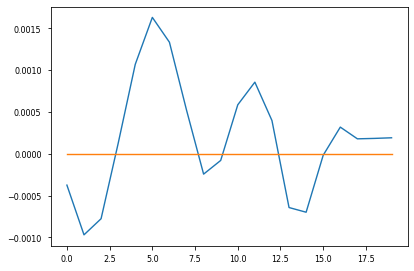

In [42]:
jac = unstack(res.jac)
plot(jac.real)
plot(jac.imag)

num function evaluations: 540


/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


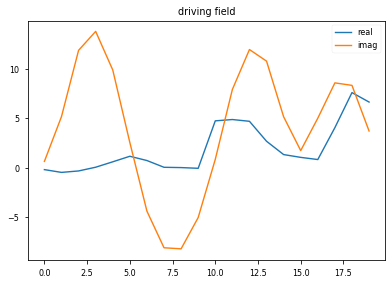

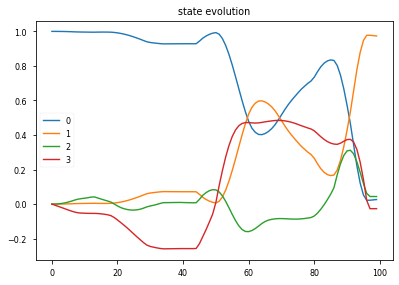

In [54]:
drv = unstack(res.x)
plot(drv.real, label='real')
plot(drv.imag, label='imag')
title('driving field')
legend()

states = just_run(drv)
figure()
plot(states[:,:,50])
title('state evolution')
legend(np.arange(4))